In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform

import SIRD_Model

In [2]:
# Dictionary of numerical IDs for each of the 50 states
stateIds={'AK': 1, 'AL': 2, 'AR': 3, 'AZ': 4, 'CA': 5, 'CO': 6, 'CT': 7, 'DE': 8, 'FL': 9, 'GA': 10, 'HI': 11, 'ID': 12, 'IL': 13, 'IN': 14, 'IA': 15, 'KS': 16, 'KY': 17, 'LA': 18, 'ME': 19, 'MD': 20, 'MA': 21, 'MI': 22, 'MN': 23, 'MS': 24, 'MO': 25, 'MT': 26, 'NE': 27, 'NV': 28, 'NH': 29, 'NJ': 30, 'NM': 31, 'NY': 32, 'NC': 33, 'ND': 34, 'OH': 35, 'OK': 36, 'OR': 37, 'PA': 38, 'RI': 39, 'SC': 40, 'SD': 41, 'TN': 42, 'TX': 43, 'UT': 44, 'VT': 45, 'VA': 46, 'WA': 47, 'WV': 48, 'WI': 49, 'WY': 50}

In [3]:
class CovidTimeSeries(object):
    """ Stores the JHU time series data for a county for covid """
    def __init__(self):
        self.regionName=None
        self.positive=None  #Infected used by the paper
        self.Lat=None 
        self.Long=None
        self.healed=None   #Recovered
        self.totalCases=None
        self.deaths=None 

class CovidDatabase(object):
    """ Stores the covid-19 data"""
    def __init__(self):
        self.CovidData={}
        self.DateRange=[]
      
    def loadTimeSeries(self, filenameI, startdate, enddate):
        """ load the infections data from filenameI and death data from filenameD
            from startdate to enddate
        """
        csvfile=open(filenameI, newline='')
        rd = csv.reader(csvfile, delimiter=',')
        data=[]
        for lv in rd:
                # Place data at front of list since dates in data are reversed
                data.insert(0, lv)

        header=data[0]
        
        infectionData=(data[1:])
        temp = np.array(infectionData)
        dates = temp[:,0]
        dates = dates.tolist()

        CountyD={}
        N=len(infectionData);
        
        hasRecovered = []
        
        for i in range(N):
            if infectionData[i][1] not in stateIds:
                # If the state code isn't a valid code, skip it
                continue
            if not startdate <= infectionData[i][0] <= enddate:
                continue
            if stateIds[infectionData[i][1]] not in CountyD: #if key not already initialized
                c1=CovidTimeSeries()
                c1.regionName = infectionData[i][1]
                # Place all states at null island so we can process the rest of the simulation
                c1.Lat = 0.0 #float(infectionData[i][4])
                c1.Long = 0.0 #float(infectionData[i][5])
                # TODO: make and parse list of states with numeric ids
                x=stateIds[infectionData[i][1]]
                # Check for empty strings to avoid conversion errors
                c1.deaths = [float(infectionData[i][3]) if infectionData[i][3] else 0.0]
                c1.positive = [float(infectionData[i][19]) if infectionData[i][19] else 0.0]
                c1.totalCases = [float(infectionData[i][19]) if infectionData[i][19] else 0.0]
                c1.healed = [float(infectionData[i][28]) if infectionData[i][28] else 0.0]
                if infectionData[i][28]:
                    hasRecovered.append(infectionData[i][1])
                CountyD[x]=c1
            else: #if key already initialized
                x=stateIds[infectionData[i][1]]
                CountyD[x].deaths.append(float(infectionData[i][3]) if infectionData[i][3] else 0.0)
                CountyD[x].positive.append(float(infectionData[i][19]) if infectionData[i][19] else 0.0)
                CountyD[x].totalCases.append(float(infectionData[i][19]) if infectionData[i][19] else 0.0)
                CountyD[x].healed.append(float(infectionData[i][28]) if infectionData[i][28] else 0.0)
                if infectionData[i][28] and infectionData[i][1] not in hasRecovered:
                    hasRecovered.append(infectionData[i][1])
          
        print(hasRecovered)
        
        for key in CountyD: #Turn the lists into arrays
            CountyD[key].deaths = np.array(CountyD[key].deaths)
            CountyD[key].positive = np.array(CountyD[key].positive)
            CountyD[key].healed = np.array(CountyD[key].healed)
            CountyD[key].totalCases = np.array(CountyD[key].totalCases)

             
        self.DateRange=dates
        self.CovidData=CountyD
        
        
class CovidTrackingDatabase(object):
    """ Stores the covid-19 data"""
    def __init__(self):
        self.CovidData={}
        self.DateRange=[]
      
    def loadTimeSeries(self, filenameI, startdate, enddate, fields):
        """ load the infections data from filenameI and death data from filenameD
            from startdate to enddate
        """
        csvfile=open(filenameI, newline='',  encoding='UTF-8')
        rd = csv.reader(csvfile, delimiter=',')
        data=[]
        for lv in rd:
            if(lv[0] == 'date'): #keep the header first
                data.insert(0,lv)
            data.insert(1,lv) #invert the dates because they appear in opposite order
        header=data[0]
        
        infectionData=(data[1:])
        temp = np.array(infectionData)
        dates = temp[:,0]
        dates = dates.tolist()


        startdate_index=dates.index(startdate)
        enddate_index=dates.index(enddate)
        dRange = enddate_index - startdate_index + 1

        CountyD={}
        N=len(infectionData);
        for i in range(N):
            if not startdate<= infectionData[i][0] <= enddate:
                continue
            if infectionData[i][1] not in CountyD: #if key not already initialized
            
                c1=CovidTimeSeries()
                
                fp=infectionData[i][1]
                x=fp
                c1.dates = [infectionData[i][0]]
                c1.regionName = infectionData[i][1]
                if(infectionData[i][header.index(fields[2])] == ''): #For each if and else, change the field subscript
                                                            #to match what order they appear in the field parameter
                    c1.hospitalized = [float(0)]
                else:
                    c1.hospitalized = [float(infectionData[i][header.index(fields[2])])]
                    
                if(infectionData[i][header.index(fields[0])] == ''):
                    c1.deaths = [float(0)]
                else:
                    c1.deaths = [float(infectionData[i][header.index(fields[0])])]  
                    
                if(infectionData[i][header.index(fields[1])] == ''):
                    c1.positive = [float(0)]
                else:
                    c1.positive = [float(infectionData[i][header.index(fields[1])])]      
               
                if(infectionData[i][header.index(fields[3])] == ''):
                    c1.healed = [float(0)]
                else:
                    c1.healed = [float(infectionData[i][header.index(fields[3])])]  
              
                CountyD[x]=c1
            else: #if key already initialized
                fp=infectionData[i][1]
                x=fp
                if(infectionData[i][header.index(fields[2])] == ''): #For each if and else, change the field subscript
                                                            #to match what order they appear in the field parameter
                    CountyD[x].hospitalized.append(float(0))
                else:
                    CountyD[x].hospitalized.append(float(infectionData[i][header.index(fields[2])]))
                    
                if(infectionData[i][header.index(fields[1])] == ''):
                    CountyD[x].positive.append(float(0))
                else:
                    CountyD[x].positive.append(float(infectionData[i][header.index(fields[1])])) 
                    
                if(infectionData[i][header.index(fields[0])] == ''):
                    CountyD[x].deaths.append(float(0))
                else:
                    CountyD[x].deaths.append(float(infectionData[i][header.index(fields[0])]))
                    
                if(infectionData[i][header.index(fields[3])] == ''):
                    CountyD[x].healed.append(float(0))
                else:
                    CountyD[x].healed.append(float(infectionData[i][header.index(fields[3])]))

                CountyD[x].dates.append(infectionData[i][0])
               
        for key in CountyD: #Turn the lists into arrays
            CountyD[key].deaths = np.array(CountyD[key].deaths)
            CountyD[key].positive = np.array(CountyD[key].positive)
            CountyD[key].healed = np.array(CountyD[key].healed)
            CountyD[key].totalCases = np.array(CountyD[key].totalCases)
            CountyD[key].dates = np.array(CountyD[key].dates)
            CountyD[key].hospitalized = np.array(CountyD[key].hospitalized)
        self.DateRange=dRange
        self.CovidData=CountyD

def loadData(data):
    
    header = data[0] #get the labels
    infectionData=(data[1:]) #data without the labels
    infectionData = np.array(infectionData)
    dates = infectionData[:,0]
    infected = infectionData[:,1]
    hospitalized = infectionData[:,2]
    recovered = infectionData[:,3]
    deaths = infectionData[:,4]
    deaths = deaths.astype(float)
    recovered = recovered.astype(float)
    infected = infected.astype(float)
    hospitalized = hospitalized.astype(float)
    return dates, infected, hospitalized, recovered, deaths

def loadFile(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd: #generating the data matrix
        data.append(lv)
    header = data[0] #get the labels
    infectionData=(data[1:]) #data without the labels
    infectionData = np.array(infectionData)
    dates = infectionData[:,0]
    infected = infectionData[:,1]
    hospitalized = infectionData[:,2]
    recovered = infectionData[:,3]
    deaths = infectionData[:,4]
    deaths = deaths.astype(float)
    recovered = recovered.astype(float)
    infected = infected.astype(float)
    hospitalized = hospitalized.astype(float)
    return dates, infected, tested, recovered, deaths

In [4]:
pathc="../Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")

fullDataName="all-states-history.csv"

startdate='1/13/2020'
enddate='3/7/2021'

database=CovidTrackingDatabase();
fields = ['death', 'positive', 'hospitalized','recovered']
database.loadTimeSeries(pathc+fullDataName, startdate, enddate,fields)

# States with recovered data
'WY', 'MN', 'ME', 'AR', 'SD', 'IA', 'DE', 'ND', 'MD', 'NM', 'TX', 'VT', 'TN', 'NH', 'HI', 'OK', 'MI', 'AK', 'MT', 'WV', 'KY', 'UT', 'ID', 'SC', 'LA', 'MS', 'WI', 'OR', 'PA', 'AL', 'MA', 'NE'

In [5]:
CountyD=database.CovidData
state = 'WA' #State you want data for
save = False
for key in CountyD: #generates the wanted array in correct format
    wanted = np.zeros((np.shape(CountyD[key].dates)[0],5))
    wanted = wanted.tolist()
    break
for key in CountyD:
    if CountyD[key].regionName == state:
        tempDeaths = CountyD[key].deaths
        tempRecovered = CountyD[key].healed
        tempInfected = CountyD[key].positive
        tempHosp = CountyD[key].hospitalized
        tempDates = CountyD[key].dates
        for N in range(np.shape(CountyD[key].dates)[0]): #Correctly formatted array
            wanted[N][0] = tempDates[N]
            wanted[N][1] = tempInfected[N]
            wanted[N][2] = tempHosp[N]
            wanted[N][3] = tempRecovered[N]
            wanted[N][4] = tempDeaths[N]
#wanted contains all of the data needed in correct format, can easily be saved
if(save):
    filename = "../Data/"+state+".csv"
    fields = ['Dates', 'Infected','Hospitalized', 'Recovered', 'Deaths']
    # writing to csv file 
    with open(filename, 'w', newline = '') as csvfile: 
    # creating a csv writer object 
        csvwriter = csv.writer(csvfile, delimiter = ',') 
        
    # writing the fields 
        csvwriter.writerow(fields) 
        
    # writing the data rows 
        csvwriter.writerows(wanted)
dates, infected, hospitalized, recovered, deaths = loadData(wanted)

# Raw Infected and Recovered Data

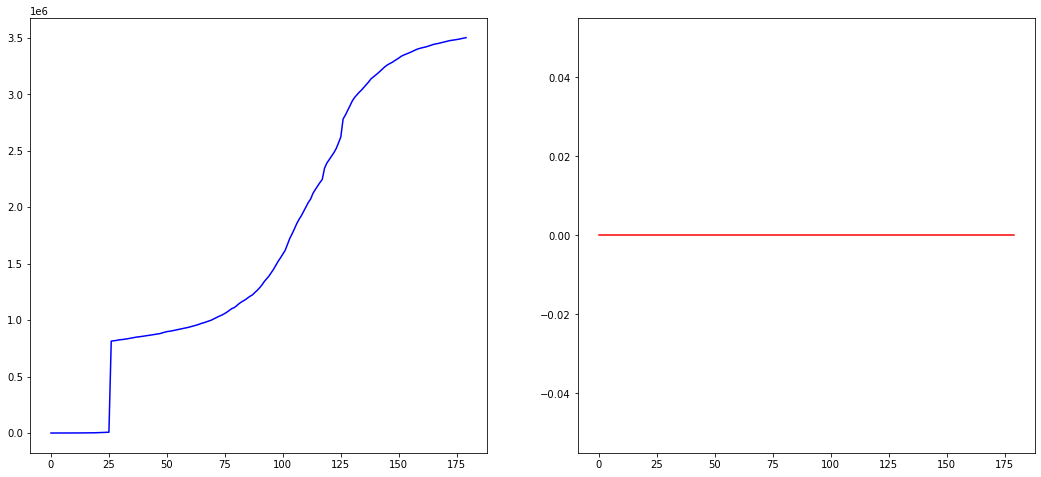

In [6]:
k1 = "CA" #California
d1 = database.CovidData[k1].positive
i1=database.CovidData[k1].healed

fig2, ax2=plt.subplots(1, 2, figsize=(18,8))
ax2[0].plot(d1, color='blue', label='infections')
ax2[1].plot(i1, color='red', label='recovered')

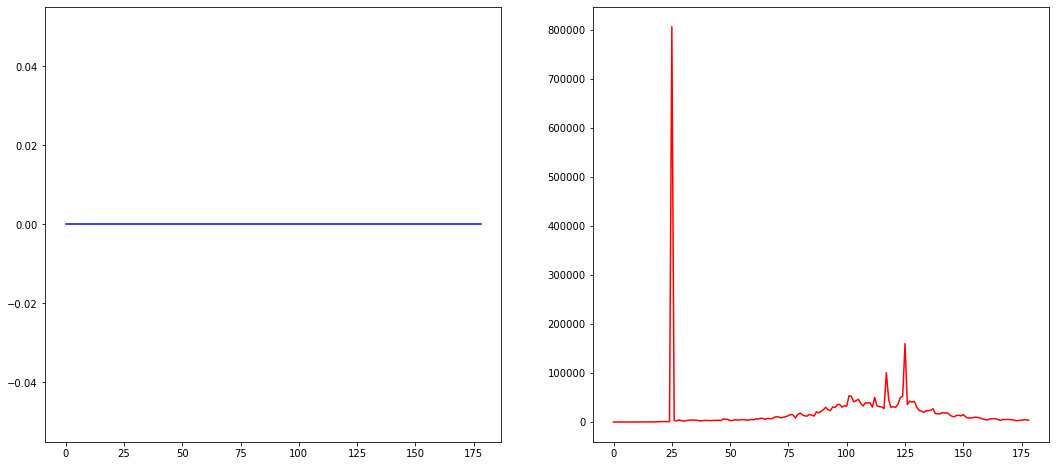

In [7]:
ri1=np.diff(i1)
rd1=np.diff(d1)
fig2, ax2=plt.subplots(1, 2, figsize=(18,8))
ax2[0].plot(ri1, color='blue', label='infections')
ax2[1].plot(rd1, color='red', label='deaths')

# Smoothing Kernel

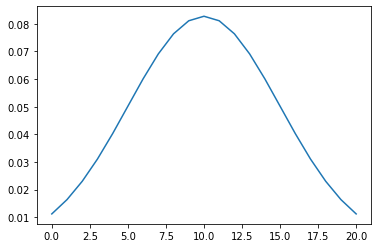

In [8]:
sigma = 5
conSize = 10
x2 = np.arange(-conSize, 1 + conSize)
kernel2 = np.exp(-(x2) ** 2 / (2 * sigma ** 2))
kernel2=kernel2/sum(kernel2)
plt.plot(kernel2)

# Raw Data

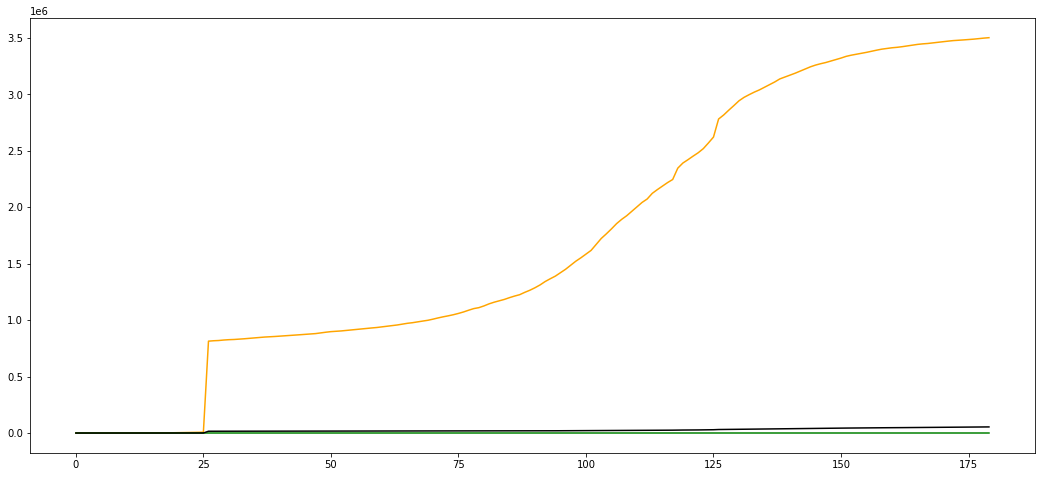

In [9]:
popITA = 4000000 #Very rought estimate just for exerimentation, assume population of california is 40 million
infectRaw = database.CovidData[k1].positive
recovRaw = database.CovidData[k1].healed
deadRaw = database.CovidData[k1].deaths
susceptRaw = popITA - infectRaw - recovRaw - deadRaw #S + I + R + D = totalPop

fig, ax = plt.subplots(figsize=(18,8))
#ax.plot(suscept, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
ax.plot(infectRaw, color='orange', label='infected')
ax.plot(recovRaw, color='green', label='recovered')
ax.plot(deadRaw, color='black', label='dead')

# Smoothed Data

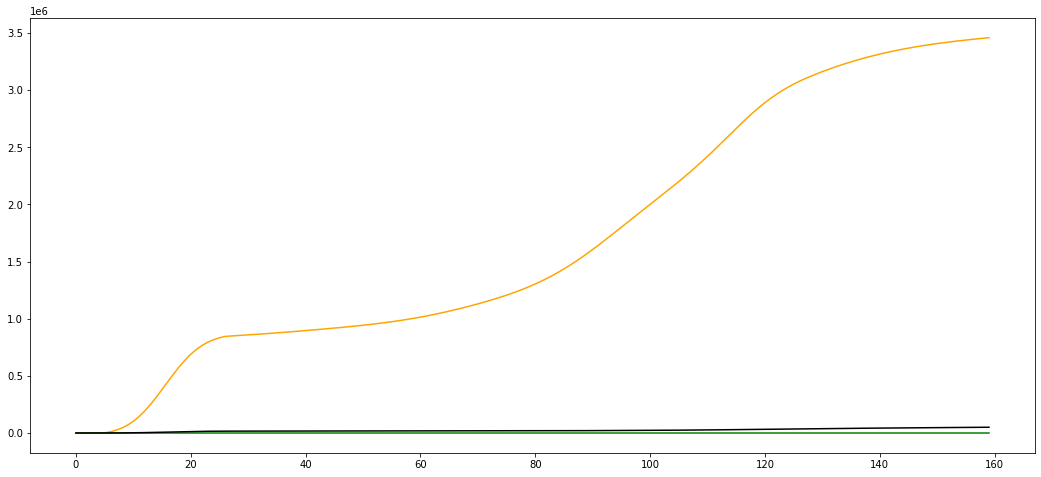

In [10]:
#option for use of raw numbers for data, no smoothing
#infect = infectRaw
#recov = recovRaw
#dead = deadRaw
#suscept = susceptRaw

#convolve the data to smooth out, valid mode keeps bound points realistic
infect = np.convolve(infectRaw, kernel2, 'valid')
recov = np.convolve(recovRaw, kernel2, 'valid')
dead = np.convolve(deadRaw, kernel2, 'valid')
suscept = popITA - infect - recov - dead #S + I + R + D = totalPop

fig, ax = plt.subplots(figsize=(18,8))
#ax.plot(suscept, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
ax.plot(infect, color='orange', label='infected')
ax.plot(recov, color='green', label='recovered')
ax.plot(dead, color='black', label='dead')

### Modeling $\gamma$ (recovery rate), $\beta$ (transmission rate), and $\upsilon$ (death rate).

$S(t+1) = -\beta S(t)I(t) + S(t)$

$I(t+1) = \beta S(t)I(t) - \gamma I(t) - \upsilon I(t) + I(t)$

$R(t+1) = \gamma I(t) + R(t)$

$D(t+1) = \upsilon I(t) + D(t)$

### As a matrix

$\begin{bmatrix}
S(t+1) \\ I(t+1) \\ R(t+1) \\ D(t+1)
\end{bmatrix}
=
\begin{bmatrix}
S(t) & -S(t)I(t) & 0 & 0 \\
I(t) & S(t)I(t) & -I(t) & -I(t) \\
R(t) & 0 & I(t) & 0 \\
D(t) & 0 & 0 & I(t)
\end{bmatrix}
\begin{bmatrix}
1 \\ \beta \\ \gamma \\ \upsilon
\end{bmatrix}$

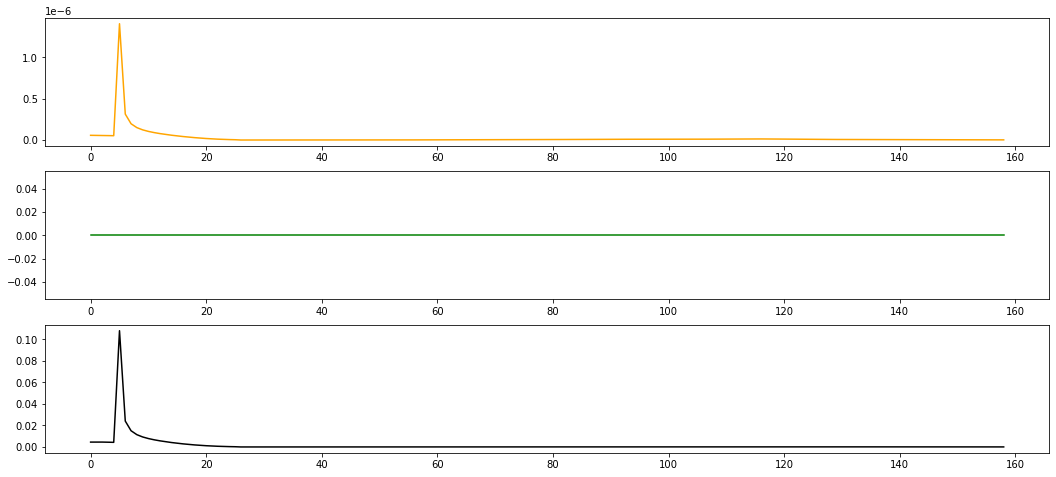

In [11]:
sirdMatrix = np.zeros((len(recov) - 1, 4, 4))
nextIterMatrix = np.zeros((len(recov) - 1, 4, 1)) #the S(t+1), I(t+1), ... matrix

#populate the 4x4 matrix with parameters (see above note)
sirdMatrix[:,0,0] = suscept[0:-1]
sirdMatrix[:,0,1] = -suscept[0:-1] * infect[0:-1]

sirdMatrix[:,1,0] = infect[0:-1]
sirdMatrix[:,1,1] = suscept[0:-1] * infect[0:-1]
sirdMatrix[:,1,2] = -infect[0:-1]
sirdMatrix[:,1,3] = -infect[0:-1]

sirdMatrix[:,2,0] = recov[0:-1]
sirdMatrix[:,2,2] = infect[0:-1]

sirdMatrix[:,3,0] = dead[0:-1]
sirdMatrix[:,3,3] = infect[0:-1]

#populate the S(t+1), I(t+1), ... matrix
nextIterMatrix[:,0,0] = suscept[1:]
nextIterMatrix[:,1,0] = infect[1:]
nextIterMatrix[:,2,0] = recov[1:]
nextIterMatrix[:,3,0] = dead[1:]

paramMatrix = np.linalg.solve(sirdMatrix, nextIterMatrix) #solve Ax = B, where A = sirdMatrix, and B = nextIterMatrix

#copy params over from the solved matrix
transRate = paramMatrix[:,1,0] #beta
recovRate = paramMatrix[:,2,0] #gamma
deathRate = paramMatrix[:,3,0] #upsilon

#plot rates over time
fig, ax = plt.subplots(3, 1, figsize=(18,8))
ax[0].plot(transRate, color='orange', label='Transmission Rate')
ax[1].plot(recovRate, color='green', label='Recovery Rate')
ax[2].plot(deathRate, color='black', label='Death Rate')

### An attempt at matching the results of the paper

The paper uses the first 120 days and plots the results.
The results below are very close (the recovery rate is slightly different, the paper seems to have used a lot more smoothing).

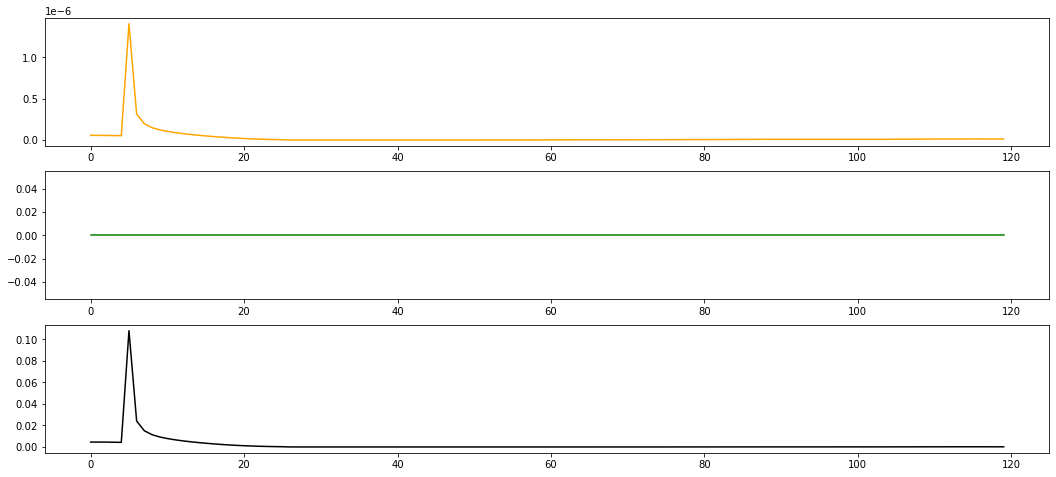

In [12]:
#graph only the first ~100-120 days (remember the first some days are removed when smoothing)
fig, ax = plt.subplots(3, 1, figsize=(18,8))
ax[0].plot(transRate[0:120], color='orange', label='Transmission Rate')
ax[1].plot(recovRate[0:120], color='green', label='Recovery Rate')
ax[2].plot(deathRate[0:120], color='black', label='Death Rate')